# RNN for text classification and text generation
### Dr. Omri Allouche 2021. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/rnn_text_classification_generation/DL_rnn_text_classification_generation.ipynb)

In the first part of this exercise, we’ll continue our attempts to classify text using different network architectures. This time, we’ll try a LSTM. We'll use the Metrolyrics dataset we used in the previous exercise.  

You are encouraged to review the code in [this](https://github.com/prakashpandey9/Text-Classification-Pytorch) repo, that contains implementation of several deep learning architectures for text classification in PyTorch. If you face time limitations, you're welcome to adapt it to your needs instead of writing your own code from scratch.

In the second part of this exercise, you'll unleash the hidden creativity of your computer, by letting it generate Country songs (yeehaw!). You'll train a character-level RNN-based language model, and use it to generate new songs.


### Special Note
Our Deep Learning course was packed with both theory and practice. In a short time, you've got to learn the basics of deep learning theory and get hands-on experience training and using pretrained DL networks, while learning PyTorch.  
Past exercises required a lot of work, and hopefully gave you a sense of the challenges and difficulties one faces when using deep learning in the real world. While the investment you've made in the course so far is enormous, I strongly encourage you to take a stab at this exercise. 

DL networks for NLP are much shallower than those for image classification. It's possible to construct your own networks from scratch, and achieve nice results. While I hope the theoretical foundations of RNNs are clear after our class sessions, getting your hands dirty with their implementation in PyTorch allows you to set breakpoints, watch the dimensions of the different layers and components and get a much better understand of theory, in addition to code that might prove useful later for your own projects. 

I tried to provide references for all parts that walk you through a very similar task (actually, the same task on a different dataset). I expect this exercise to require much less of your time than previous exercises.

The exercise is aimed to help you get better understanding of the concepts. I am not looking for the optimal model performance, and don't look for extensive optimization of hyperparameters. The task we face in this exercise, namely the classification of the song’s genre from its text alone, is quite challenging, and we probably shouldn’t expect great results from our classifier. Don’t let this discourage you - not every task reaches an f1 score of 90%+. 

In fact, some of the reasons I chose this dataset is because it highlights some of the issues we face in machine learning models in the real world. Examples include:
- The classes are highly imbalanced - try to think how this affects the network learning
- Given the small amount of data for some classes, you might actually prefer to remove them from the dataset. How would you decide that?
- NLP tasks often involve preprocessing (lowercasing, tokenization, lemmatization, stopwords removal etc.). The decision on the actual preprocessing pipeline depends on the task, and is often influenced by our believes about the data and exploratory analysis of it. Thinking conciously about these questions helps you be a better data scientist
- Some songs contain no lyrics (for example, they just contain the text "instrumental"). Others include non-English characters. You'll often need to preprocess your data and make decisions as to what your network should actually get as input (think - how should you treat newline characters?)
- While model performance on this dataset are not amazing, we can try to answer interesting follow-up questions - which genres are more similar to each other and are often confused? Do genres become more similar through the years? ...

More issues will probably pop up while you're working on this task. If you face technical difficulties or find a step in the process that takes too long, please let me know. It would also be great if you share with the class code you wrote that speeds up some of the work (for example, a data loader class, a parsed dataset etc.)

## RNN for Text Classification
In this section you'll write a text classifier using LSTM, to determine the genre of a song based on its lyrics.  
The code needed for this section should be very similar to code you've written for the previous exercise, and use the same dataset.  

In [1]:
%%capture
!pip install git+https://github.com/PyTorchLightning/metrics

In [24]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchmetrics
import numpy as np
from IPython.display import clear_output
try:
  from torchtext import datasets
  from torchtext.data import Field, LabelField
  from torchtext.data import BucketIterator, Dataset, Example
except:
  from torchtext.legacy import datasets
  from torchtext.legacy.data import Field, LabelField
  from torchtext.legacy.data import BucketIterator, Dataset, Example

from torchtext.vocab import Vectors, GloVe
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
class LyricsDataset(Dataset):

    def __init__(self, data, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for row in data.itertuples():
            label = row.genre
            text = row.sent
            examples.append(Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

In [5]:
url = 'http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet?raw=true'
songs_df = pd.read_parquet(url)
songs_df = songs_df.reset_index(drop=True)

In [6]:
# a bit of hack
songs_df.sent = songs_df.song + "\n" + songs_df.artist + "\n" + songs_df.sent

In [7]:
TEXT_FIELD = Field(sequential=True, lower=True, include_lengths=True)
LABEL_FIELD = LabelField(dtype=torch.float) 

lyrics_ds = LyricsDataset(songs_df, text_field=TEXT_FIELD, label_field=LABEL_FIELD)

In [8]:
train, test = lyrics_ds.split(split_ratio=0.85, stratified=True, strata_field="label")
train, valid = train.split(split_ratio=0.9, random_state=random.seed(SEED))

In [9]:
TEXT_FIELD.build_vocab(train, vectors="fasttext.en.300d")
LABEL_FIELD.build_vocab(train)

.vector_cache/wiki.en.vec: 6.60GB [04:50, 22.7MB/s]                            
100%|█████████▉| 2518447/2519370 [04:00<00:00, 11067.23it/s]

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size = 64,
    sort_within_batch = True,
    device = device)

In [11]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, word_embeddings, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.data.copy_(word_embeddings)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                        dropout=dropout, bidirectional=bidirectional)
        
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
           
        # workaround because of https://github.com/pytorch/pytorch/issues/43227

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded.cpu(), text_lengths.cpu()).to(device)
        
        if isinstance(self.rnn, nn.LSTM):
          packed_output, (hidden, cell) = self.rnn(packed_embedded)
        else:
          packed_output, hidden = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions] or [batch_size, hid dim * num directions]
            
        return self.fc(hidden)

In [12]:
songs_df.genre.unique()

array(['Pop', 'Hip-Hop', 'Rock', 'Country', 'Metal'], dtype=object)

In [13]:
cls2idx = {'Pop':0, 'Hip-Hop':1, 'Rock':2, 'Country':3, 'Metal':4}
idx2cls = {v:k for k, v in cls2idx.items()}
vocab_size = len(TEXT_FIELD.vocab)
emb_dim = 300
hidden_dim = 1024
output_dim = len(idx2cls)
n_layers = 2
bidirectional = True
dropout = 0.5
PAD_IDX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.pad_token]
patience=3

In [14]:
model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    word_embeddings = TEXT_FIELD.vocab.vectors,
    pad_idx=PAD_IDX
).to(device)

In [15]:
def plot_learning_curves(metric_history, title=""):
    with plt.style.context('seaborn-whitegrid'):
      fig,ax = plt.subplots(1,2, figsize=(16, 6))
      train_history = pd.DataFrame(metric_history["train"]).reset_index()
      val_history = pd.DataFrame(metric_history["val"]).reset_index()
      train_history.plot(x="epoch", y="acc", ax=ax[0], color="r", label="acc_train") 
      val_history.plot(x="epoch", y="acc", ax=ax[0], color="b", label="acc_val")
      train_history.plot(x="epoch", y="loss", color="r", ax=ax[1], label="loss_train")
      val_history.plot(x="epoch", y="loss", color="b", ax=ax[1], label="loss_val")
      ax[0].set_title(f'Train Acc: {train_history.iloc[-1]["acc"]:.4f} Val Acc: {val_history.iloc[-1]["acc"]:.4f}')
      ax[1].set_title(f'Train Loss: {train_history.iloc[-1]["loss"]:.4f} Val Loss: {val_history.iloc[-1]["loss"]:.4f}')
      if not title:
        fig.suptitle(title)
      plt.show();

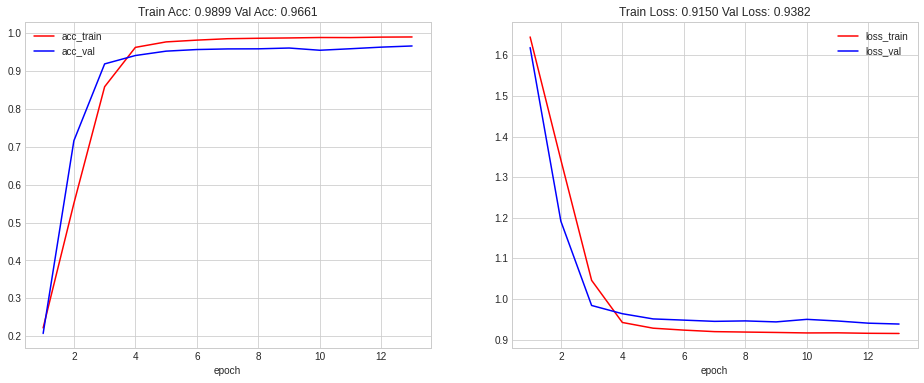

<All keys matched successfully>

In [16]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
max_epochs = 20
min_loss = np.inf
max_f1 = 0
cur_patience = 0
max_grad_norm = 2
metric_history = {"train":[], "val":[]} 

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    train_acc = torchmetrics.Accuracy().to(device)
    train_f1 = torchmetrics.F1().to(device)
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        optimizer.zero_grad()
        text, text_lengths = batch.text
        target = batch.label.long()
        predictions = F.softmax(model(text, text_lengths), dim=-1)
        f1 = train_f1(predictions, target)
        acc = train_acc(predictions, target)
        loss = criterion(predictions, target)
        loss.backward()
        if max_grad_norm is not None:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_iter)
    train_acc = train_acc.compute().item()
    train_f1 = train_f1.compute().item()
    metric_history["train"].append({"epoch": epoch,"loss":train_loss, "acc":train_acc, "f1":train_f1})
    val_loss = 0.0
    val_acc = torchmetrics.Accuracy().to(device)
    val_f1 = torchmetrics.F1().to(device)
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        text, text_lengths = batch.text
        target = batch.label.long()
        predictions = F.softmax(model(text, text_lengths), dim=-1)
        f1 = val_f1(predictions, target)
        acc = val_acc(predictions, target)
        loss = criterion(predictions, target)
        val_loss += loss.item()
    
    val_loss /= len(valid_iter)
    val_acc = val_acc.compute().item()
    val_f1 = val_f1.compute().item()
    metric_history["val"].append({"epoch": epoch,"loss":val_loss, "acc":val_acc, "f1":val_f1})
    # if val_loss < min_loss:
    #     min_loss = val_loss
    #     best_model = model.state_dict()
    if val_f1 > max_f1:
        max_f1 = val_f1
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, train loss: {}, val loss: {}, train acc: {}, val acc: {}, train f1: {}, val f1: {}'.format(epoch, train_loss, val_loss, train_acc, val_acc, train_f1, val_f1))
    clear_output(wait=True)
    plot_learning_curves(metric_history)
model.load_state_dict(best_model)

In [17]:
from sklearn.metrics import classification_report

In [18]:
@torch.no_grad()
def test_evaluating(model, iterator, criterion):
    test_loss = 0.
    test_acc = torchmetrics.Accuracy().to(device)
    test_f1 = torchmetrics.F1().to(device)
    model.eval()
    all_targets = []
    all_predictions = []
    for batch in iterator:
        text, text_lengths = batch.text
        target = batch.label.long()
        all_targets.extend(list(target.detach().cpu().numpy()))
        predictions = F.softmax(model(text, text_lengths), dim=-1)
        all_predictions.extend(list(predictions.argmax(-1).detach().cpu().numpy()))
        f1 = test_f1(predictions, target)
        acc = test_acc(predictions, target)
        loss = criterion(predictions, target)
        test_loss += loss.item()
    print(classification_report(np.array(all_targets), np.array(all_predictions), target_names=list(cls2idx.keys())))
    return {
        "test_loss": test_loss / len(iterator), 
        "test_acc": test_acc.compute().item(), 
        "test_f1": test_f1.compute().item()
    }

In [19]:
test_evaluating(model, test_iter, criterion)

              precision    recall  f1-score   support

         Pop       0.98      0.92      0.95      1760
     Hip-Hop       0.98      0.94      0.96      1620
        Rock       0.87      0.99      0.92      1460
     Country       0.98      0.98      0.98      1416
       Metal       0.99      0.98      0.99      1241

    accuracy                           0.96      7497
   macro avg       0.96      0.96      0.96      7497
weighted avg       0.96      0.96      0.96      7497



{'test_acc': 0.9578498005867004,
 'test_f1': 0.9578498005867004,
 'test_loss': 0.9465988389516281}

## RNN for Text Generation
In this section, we'll use an LSTM to generate new songs. You can pick any genre you like, or just use all genres. You can even try to generate songs in the style of a certain artist - remember that the Metrolyrics dataset contains the author of each song. 

For this, we’ll first train a character-based language model. We’ve mostly discussed in class the usage of RNNs to predict the next word given past words, but as we’ve mentioned in class, RNNs can also be used to learn sequences of characters.

First, please go through the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) on generating family names. You can download a .py file or a jupyter notebook with the entire code of the tutorial. 

As a reminder of topics we've discussed in class, see Andrej Karpathy's popular blog post ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). You are also encouraged to view [this](https://gist.github.com/karpathy/d4dee566867f8291f086) vanilla implementation of a character-level RNN, written in numpy with just 100 lines of code, including the forward and backward passes.  

Other tutorials that might prove useful:
1. http://warmspringwinds.github.io/pytorch/rnns/2018/01/27/learning-to-generate-lyrics-and-music-with-recurrent-neural-networks/
1. https://github.com/mcleonard/pytorch-charRNN
1. https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

## Eminem generator

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as Functional
import numpy as np
import re
import string
import random
import pandas as pd

In [26]:
url = 'http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet?raw=true'
songs_df = pd.read_parquet(url)
songs_df = songs_df.reset_index(drop=True)

In [27]:
text = "\n".join(songs_df[songs_df.artist=="eminem"].lyrics.tolist())
text = text.replace("\n\n", "\n")

In [28]:
def clean_lyric(lyric):
    return re.sub("[^a-z' ]", "", lyric).replace("'", "")

In [29]:
lyrics = text.lower().split("\n")
lyrics = np.unique(lyrics)[1:].tolist()

cleaned_lyrics = [clean_lyric(lyric) for lyric in lyrics]

In [30]:
# for making generative text, we need to define a sequence size which we can chunk our lyrics into
seq_size = 5

In [31]:
def create_sequences(lyric, seq_len):
    # intialize sequences list
    sequences = []
    
    # returns early if not long enough
    if len(lyric.split()) <= seq_len:
        return [lyric]
    
    # adds every possible sequence
    for itr in range(seq_len, len(lyric.split())):
        curr_seq = lyric.split()[itr - seq_len:itr + 1]
        sequences.append(" ".join(curr_seq))
    
    # returns the sequences
    return sequences

In [32]:
# obtain every sequence
raw_sequences = [create_sequences(lyric, seq_size) for lyric in cleaned_lyrics]

# filter to get the unique sequences
sequences = np.unique(np.array(sum(raw_sequences, []))).tolist()

In [33]:
uniq_words = np.unique(np.array(" ".join(sequences).split(" ")))
uniq_words_idx = np.arange(uniq_words.size)

word_to_idx = dict(zip(uniq_words.tolist(), uniq_words_idx.tolist()))
idx_to_word = dict(zip(uniq_words_idx.tolist(), uniq_words.tolist()))

vocab_size = len(word_to_idx)
vocab_size

10615

In [34]:
# intialize the empty lists
x_word = []
y_word = []

# iterate through every sequence
for seq in sequences:
    
    # stop if the sequence isn't long enough
    if (len(seq.split()) != seq_size + 1):
        continue
    
    # add the words to the sequences
    x_word.append(" ".join(seq.split()[:-1]))
    y_word.append(" ".join(seq.split()[1:]))

In [35]:
def get_seq_idx(seq):
    return [word_to_idx[word] for word in seq.split()]

In [36]:
x_idx = np.array([get_seq_idx(word) for word in x_word])
y_idx = np.array([get_seq_idx(word) for word in y_word])

In [37]:
num_hidden = 256
num_layers = 4
embed_size = 200
drop_prob = 0.3
lr = 0.001
num_epochs = 20
batch_size = 32

In [38]:
class LyricLSTM(nn.Module):
    
    def __init__(self, num_hidden, num_layers, embed_size, drop_prob, lr):
        super().__init__()
        
        self.drop_prob = drop_prob
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.lr = lr
        
        self.embedded = nn.Embedding(vocab_size, embed_size)

        self.lstm = nn.LSTM(embed_size, num_hidden, num_layers, dropout = drop_prob, batch_first = True)
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(num_hidden, vocab_size)      
    
    def forward(self, x, hidden):
        
        embedded = self.embedded(x)     
        lstm_output, hidden = self.lstm(embedded, hidden)
        dropout_out = self.dropout(lstm_output).reshape(-1, self.num_hidden) 
        out = self.fc(dropout_out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.num_hidden).zero_(),
                  weight.new(self.num_layers, batch_size, self.num_hidden).zero_())
        return hidden

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LyricLSTM(num_hidden, num_layers, embed_size, drop_prob, lr).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_func = nn.CrossEntropyLoss()
model.train();

LyricLSTM(
  (embedded): Embedding(10615, 200)
  (lstm): LSTM(200, 256, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=10615, bias=True)
)

In [40]:
def get_next_batch(x, y, batch_size):
    for itr in range(batch_size, x.shape[0], batch_size):
        batch_x = x[itr - batch_size:itr, :]
        batch_y = y[itr - batch_size:itr, :]
        yield batch_x, batch_y

In [41]:
for epoch in range(num_epochs):
    hidden_layer = model.init_hidden(batch_size)
    for x, y in get_next_batch(x_idx, y_idx, batch_size):
        inputs = torch.from_numpy(x).type(torch.LongTensor).to(device)
        act = torch.from_numpy(y).type(torch.LongTensor).to(device)
        hidden_layer = tuple([layer.data for layer in hidden_layer])
        model.zero_grad()
        output, hidden = model(inputs, hidden_layer)
        loss = loss_func(output, act.view(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()           

In [59]:
from torch.nn import functional as F

UNK = len(word_to_idx)

# for changing distribution
def softmax(x, dim=None, temperature = 1.):
    e_x = torch.exp(x / temperature)
    return e_x / torch.sum(e_x, dim=dim)

def predict(model, tkn, hidden_layer):
    
         
    x = np.array([[word_to_idx[tkn] if tkn in word_to_idx else UNK]])
    inputs = torch.from_numpy(x).type(torch.LongTensor).to(device)
    # detach hidden state from history
    hidden = tuple([layer.data for layer in hidden_layer])

    out, hidden = model(inputs, hidden)
    # get the token probabilities and reshape
    # prob = F.softmax(out, dim=1).data.numpy()
    prob = softmax(out, dim=1, temperature=np.random.choice([0.5,0.2,0.1], p=[0.5, 0.25, 0.25]))
    prob = prob.detach().cpu().numpy()
    prob = prob.reshape(prob.shape[1],)
    # get indices of top 3 values
    top_tokens = prob.argsort()[-3:][::-1]
    
    # randomly select one of the three indices --> naive approach
    selected_index = top_tokens[0]

    # return word and the hidden state
    return idx_to_word[selected_index], hidden

In [43]:
def generate(model, num_words, start_text):
    
    # baseline model eval
    model.eval()
    
    # create the initial hidden layer of batch size 1
    hidden = model.init_hidden(1)
    
    # convert the starting text into tokens
    tokens = start_text.split()
    
    # iterate through and predict the next token
    for token in start_text.split():
        curr_token, hidden = predict(model, token, hidden)
    
    # add the token
    tokens.append(curr_token)
    
    # predict the subsequent tokens
    for token_num in range(num_words - 1):
        token, hidden = predict(model, tokens[-1], hidden)
        tokens.append(token)
        
    # return the formatted string
    return " ".join(tokens)

In [47]:
from nltk.tokenize import WordPunctTokenizer
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [45]:
corpus = songs_df[songs_df.artist=="eminem"]

In [48]:
tokens = [w for s in corpus.sent.tolist() for w in WordPunctTokenizer().tokenize(s) ]
word_fd = nltk.FreqDist(tokens)
bigram_fd = nltk.FreqDist(nltk.bigrams(tokens))
finder = BigramCollocationFinder(word_fd, bigram_fd)
collocations = finder.score_ngrams(bigram_measures.raw_freq)

naive auto-prompt

In [49]:
collocations = pd.DataFrame(collocations)
collocations.columns = ["col", "score"]

In [50]:
def get_lyric(start_text, num_lines):
  random_lyric = corpus.sample(1).lyrics
  num_words = list(map(lambda s:s.count(" "), next(iter(corpus.sample(1).lyrics)).split("\n")))

  lines = [generate(model, num_words[0], start_text.lower())]
  
  for i in range(num_lines - 1):
    start_text = " ".join(next(iter(collocations.sample(1)["col"])))
    lines.append(generate(model, num_words[i%len(num_words)], start_text.lower()))
    
  return "\n".join(lines)

In [52]:
print(get_lyric("I will", 25))

i will be a little
imagined marshall mathers cds in
look resenment from
swallow pride evers steppin to the core mule im a stubborn
that shook you know what im saying like im
em us in case you know what
ruin plans and i hope you hear you again
it time i dont know what im
i renovate and needed a new outfit
bury iriscience feel
eats sheep and starves lames the same time
millionaires snatchin crumbs on the floor and
til richard simmons comes to the store sweatin
chair sittin on the ground and hoped
a f that i dont need to be funded
i buzzed i think i was a gimmick
obie back at the same drum looking than
i stick up the asphalt of rolling reasons in the ground and flip
beat catchy you know what im saying like im
friends keep asking what i mean when i was in the same
tickity tock cents in a bloodier way to escape your minds like a
back steam i get dropped to the ground and pull it off when you
heads ringin like darth coochie pool up in the hospital with donovan
music go back to the next schmo

In [60]:
print(get_lyric("I will", 25))

i will be a little patient and a stringent stored
fam al un micio micio per un grammo rito posto
i buzzin i think i
from day cause the beat and the secret to hopefully
much we know what im saying like im
somewhere inside your heater you gets
stole well do that you know what im saying like im still
and tears your mother fucking hands uplook with a routine overseein you
pickin you a sin but in the same situation looking on my stinking businesses
i caught a condom and you know what im saying like im still passionate about
pet boy its okay haihai call me rabbit the same time and freely stunned and
bitch there aint no punks over here and get fucked up worse that you see you
got man pegged crazy you know what im saying like im still passionate
think things was a little urm when you could
entity tryin to figure it out of proportion feminine slugs ball i need a
better ask me for dreaming i dont know what im saying like im still passionate about
see makes you motherfuckers dont want me to be th

### Final Tips
As a final tip, I do encourage you to do most of the work first on your local machine. They say that Data Scientists spend 80% of their time cleaning the data and preparing it for training (and 20% complaining about cleaning the data and preparing it). Handling these parts on your local machine usually mean you will spend less time complaining. You can switch to the cloud once your code runs and your pipeline is in place, for the actual training using a GPU.  

I also encourage you to use a small subset of the dataset first, so things run smoothly. The Metrolyrics dataset contains over 300k songs. You can start with a much much smaller set (even 3,000 songs) and try to train a network based on it. Once everything runs properly, add more data. 

Good luck!  
Omri